# **Сравнительный анализ методов uplift-моделирования для оптимизации маркетинговых коммуникаций**

1. Скачать набор данных маркетинговых кампаний: https://www.kaggle.com/davinwijaya/customer-retention
2. Поле conversion - это целевая переменная, а offer - коммуникация. Переименовать поля (conversion -> target, offer -> treatment) и привести поле treatment к бинарному виду (1 или 0, т.е было какое-то предложение или нет) - значение No Offer означает отсутствие коммуникации, а все остальные - наличие.
3. Сделать разбиение набора данных не тренировочную и тестовую выборки.
4. Провести uplift-моделирование 3 способами:

    •	Одна модель с признаком коммуникации (S-learner).

    •	Модель с трансформацией таргета.

    •	Вариант с двумя независимыми моделями.

5. В конце вывести единую таблицу сравнения метрик uplift@10%, uplift@20% трех моделей.
6. *Для модели S-learner построить зависимость таргета (конверсии - поле conversion) от значения uplift:

    •	Сделать прогноз и получить uplift для тестовой выборки.

    •	Отсортировать тестовую выборку по uplift по убыванию.

    •	Разбить на децили.

    •	Для каждого дециля посчитать среднюю conversion.

# Подготовка данных

Установим и импортируем необходимые библиотеки.

In [ ]:
!pip install scikit-uplift

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.1/42.1 kB 2.1 MB/s eta 0:00:00


In [ ]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 9.2 MB/s eta 0:00:00


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklift.models import ClassTransformation, SoloModel, TwoModels
from sklift.metrics import qini_auc_score, uplift_at_k, uplift_by_percentile, weighted_average_uplift
from sklift.viz import plot_qini_curve, plot_uplift_curve

In [ ]:
from sklift.metrics import uplift_curve, qini_curve, uplift_auc_score
from sklift.viz import plot_uplift_curve, plot_qini_curve

Загрузим данные.

In [ ]:
!cp kaggle.json ~/.kaggle/
!chmod 600 kaggle.json
!kaggle datasets download -d davinwijaya/customer-retention

  0% 0.00/433k [00:00<?, ?B/s]
100% 433k/433k [00:00<00:00, 112MB/s]


In [ ]:
!unzip customer-retention.zip

Archive:  customer-retention.zip
  inflating: data.csv                


In [ ]:
df = pd.read_csv('data.csv')
df.head(3)

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,offer,conversion
0,10,142.44,1,0,Surburban,0,Phone,Buy One Get One,0
1,6,329.08,1,1,Rural,1,Web,No Offer,0
2,7,180.65,0,1,Surburban,1,Web,Buy One Get One,0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64000 entries, 0 to 63999
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   recency        64000 non-null  int64  
 1   history        64000 non-null  float64
 2   used_discount  64000 non-null  int64  
 3   used_bogo      64000 non-null  int64  
 4   zip_code       64000 non-null  object 
 5   is_referral    64000 non-null  int64  
 6   channel        64000 non-null  object 
 7   offer          64000 non-null  object 
 8   conversion     64000 non-null  int64  
dtypes: float64(1), int64(5), object(3)
memory usage: 4.4+ MB


Датасет содержит данные о рекламной кампании с участием 64 000 клиентов. Представлена краткая информация о клиенте, история использования скидок или акций BOGO (Buy One Get One, «купи один, получи второй бесплатно»), сделанное предложение и результат конверсии (покупка или отказ).



**Признаки:**

•	Recency – недавность, месяцев с момента последней покупки.

•	History – история, стоимость исторических покупок.

•	Used_discount – указывает, воспользовался ли клиент скидкой ранее.

•	Used_bogo – указывает, воспользовался ли клиент услугой «купи один, получи второй».

•	Zip_code – класс почтового индекса: пригородный/городской/сельский.

•	Is_referral – указывает, был ли клиент привлечён по реферальной ссылке.

•	Channel – каналы, которые использует клиент: телефон/веб/многоканальный.

•	Offer – предложения, отправленные клиентам: скидка/один за два/без предложения.

**Целевой признак:**

•	Conversion – конверсия клиентов (покупка или отказ).


Переименуем поля, как указано в задании.

In [ ]:
df.rename(columns={'conversion': 'target', 'offer': 'treatment'}, inplace=True)
df.head(3)

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,treatment,target
0,10,142.44,1,0,Surburban,0,Phone,Buy One Get One,0
1,6,329.08,1,1,Rural,1,Web,No Offer,0
2,7,180.65,0,1,Surburban,1,Web,Buy One Get One,0


Приведем treatment к бинарному виду.

In [ ]:
df['treatment'].unique()

array(['Buy One Get One', 'No Offer', 'Discount'], dtype=object)

0 - будет означать, что клиенту ничего не предложено; 1 - будет означать, что клиенту поступило какое-либо предложение: или скидка, или участие в акции.

In [ ]:
df['treatment'].replace({'No Offer': 0, 'Buy One Get One': 1, 'Discount': 1}, inplace=True)
df.head(3)

/tmp/ipython-input-1433508606.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['treatment'].replace({'No Offer': 0, 'Buy One Get One': 1, 'Discount': 1}, inplace=True)
/tmp/ipython-input-1433508606.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['treatment'].replace({'No Offer': 0, 'Buy

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,treatment,target
0,10,142.44,1,0,Surburban,0,Phone,1,0
1,6,329.08,1,1,Rural,1,Web,0,0
2,7,180.65,0,1,Surburban,1,Web,1,0


Выделим числовые и категориальные столбцы.

In [ ]:
continuos_cols = ['recency', 'history']
cat_cols = ['used_discount',	'used_bogo', 'zip_code', 'is_referral', 'channel']

Количественные признаки стандартизируем. Категориальные признаки не будем преобразовывать, так как модель самостоятельно выполнит их обработку.  

In [ ]:
scaler = StandardScaler()
scaler.fit(df[continuos_cols])
df[continuos_cols] = scaler.transform(df[continuos_cols])

Посмотрим, на сколько сбалансированы классы в treatment и target.

In [ ]:
pd.concat([df['treatment'].value_counts(), df['treatment'].value_counts(normalize=True)], axis=1)

,count,proportion
treatment,,
1,42694,0.667094
0,21306,0.332906


In [ ]:
pd.concat([df['target'].value_counts(), df['target'].value_counts(normalize=True)], axis=1)

,count,proportion
target,,
0,54606,0.853219
1,9394,0.146781


Видим, что существует проблема двойного дисбаланса: классы несбалансированны и в treatment,  и в target.

Создадим переменную для стратифицированного разбиения, чтобы учесть дисбаланс в target и treatment.

In [ ]:
stratify_col = df['target'].astype(str) + '_' + df['treatment'].astype(str)

Выполним разбиение данных со стратификацией по двум столбцам.

In [ ]:
X_train, X_test, y_train, y_test, treat_train, treat_test  = train_test_split(df.drop(columns=['target', 'treatment']), df['target'], df['treatment'], test_size=0.25, stratify=stratify_col, random_state=42)

Проверим распределение классов.

In [ ]:
print(f"Распределение в train:")
print(f"  Treatment: {treat_train.mean():.2%}")
print(f"  Target в treatment: {y_train[treat_train==1].mean():.2%}")
print(f"  Target в control: {y_train[treat_train==0].mean():.2%}")

print(f"\nРаспределение в test:")
print(f"  Treatment: {treat_test.mean():.2%}")
print(f"  Target в treatment: {y_test[treat_test==1].mean():.2%}")
print(f"  Target в control: {y_test[treat_test==0].mean():.2%}")

Распределение в train:
  Treatment: 66.71%
  Target в treatment: 16.71%
  Target в control: 10.62%

Распределение в test:
  Treatment: 66.71%
  Target в treatment: 16.70%
  Target в control: 10.61%


Распределение получилось одинаковым. Получается, что ≈66,7% клиентов получили коммуникацию, ≈33.3% не получили; в treatment группе: 16.71% откликов, в control группе: 10.62% откликов. Дисбаланс не критический, но заметный. Учтем это при дальнейшем обучении.

Выведем несколько строк получившихся датасетов, чтобы убедиться в корректности их формирования.

In [ ]:
X_train.head()

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel
36629,1.207751,-0.282349,0,1,Surburban,1,Web
27824,1.207751,-0.827992,1,0,Surburban,0,Phone
12326,1.777948,-0.741990,0,1,Surburban,0,Web
51930,1.207751,0.502600,1,0,Urban,0,Phone
12320,-0.217739,0.586650,1,0,Rural,0,Multichannel


In [ ]:
y_train.head()

,target
36629,0
27824,0
12326,0
51930,1
12320,0


In [ ]:
treat_train.head()

,treatment
36629,0
27824,1
12326,0
51930,1
12320,1


Создадим словарь для записи результатов.

In [ ]:
models_results = {'approach': [], 'uplift@10%': [], 'uplift@20%': []}

# Построение одной модели с признаком коммуникации

Построим одну модель с признаком коммуникации: модель будет обучаться на двух группах, при этом бинарный флаг коммуникации выступит в качестве дополнительного признака. Каждый объект из тестовой выборки оценим дважды: с флагом коммуникации равным 1 и равным 0. Вычитая вероятности по каждому наблюдению, получим искомый uplift.

Для построения SoloModel будем использовать CatBoostClassifier, так как это быстрая и точная модель, довольна устойчивая к переобучению. Так как в данных существует дисбаланс, зададим параметры модели auto_class_weights='Balanced' и eval_metric='AUC'.

Чтобы понять, насколько эффективно воздействие, примененное к k наиболее перспективным клиентам, используем метрику uplift_at_k. В задании указано измерить uplift 10% и 20% клиентов.


In [ ]:
sm = SoloModel(
    CatBoostClassifier(
        iterations=20,
        cat_features=cat_cols,
        eval_metric='AUC',
        auto_class_weights='Balanced',
        silent=True,
        random_state=42)
    )

sm = sm.fit(X_train, y_train, treat_train)
uplift_sm = sm.predict(X_test)

sm_score_10 = uplift_at_k(y_true=y_test, uplift=uplift_sm, treatment=treat_test, strategy='by_group', k=0.1)
sm_score_20 = uplift_at_k(y_true=y_test, uplift=uplift_sm, treatment=treat_test, strategy='by_group', k=0.2)

print(sm_score_10)
print(sm_score_20)

0.08698057233054521
0.07953412445934588


Добавим результаты в финальную таблицу.

In [ ]:
models_results['approach'].append('SoloModel')
models_results['uplift@10%'].append(sm_score_10)
models_results['uplift@20%'].append(sm_score_20)

Получим условные вероятности выполнения целевого действия при взаимодействии для каждого объекта и условные вероятности выполнения целевого действия без взаимодействия для каждого объекта.

In [ ]:
sm_trmnt_preds = sm.trmnt_preds_
sm_ctrl_preds = sm.ctrl_preds_

Выведем распределения вероятностей и их разность (uplift) на графики. Функция plot_uplift_preds строит три гистограммы (или линейных графика):

- Распределение предсказанных вероятностей для тестовой группы (treatment) – для тех, кто подергался воздействию.
- Распределение предсказанных вероятностей для контрольной группы (control) - без воздействия.
- Распределение разницы между этими вероятностями, то есть самого uplift (подъема/эффекта воздействия): в положительной части расположены клиенты, с которых необходимо начинать воздействие; в отрицательной части - те, с кем не нужно взаимодействовать.

Этот график помогает визуально оценить, насколько хорошо модель различает поведение пользователей в тестовой и контрольной группах и есть ли выраженный эффект от воздействия.

В идеале на первой гистограмме распределение должно быть сильно смещено вправо (к высоким вероятностям), что означает, что модель предсказывает высокую вероятность отклика для большинства обработанных объектов.

В идеале на второй гистограмме  распределение должно быть сильно смещено влево (к низким вероятностям), что означает, что модель предсказывает низкую вероятность отклика для большинства объектов без воздействия.

Третья гистограмма является наиболее важной для оценки качества uplift-модели. Положительные значения uplift (правая часть графика) – это целевая аудитория, объекты которой, скорее всего, совершат действие только благодаря воздействию (убеждаемые). Значения uplift около нуля показывают тех, чье поведение не изменится вне зависимости от воздействия, на них неэффективно тратить ресурсы. Отрицательные значения uplift (левая часть графика) показывают тех, кто с большей вероятностью совершит целевое действие, если их не беспокоить. Воздействие на них контрпродуктивно и может привести к потерям.



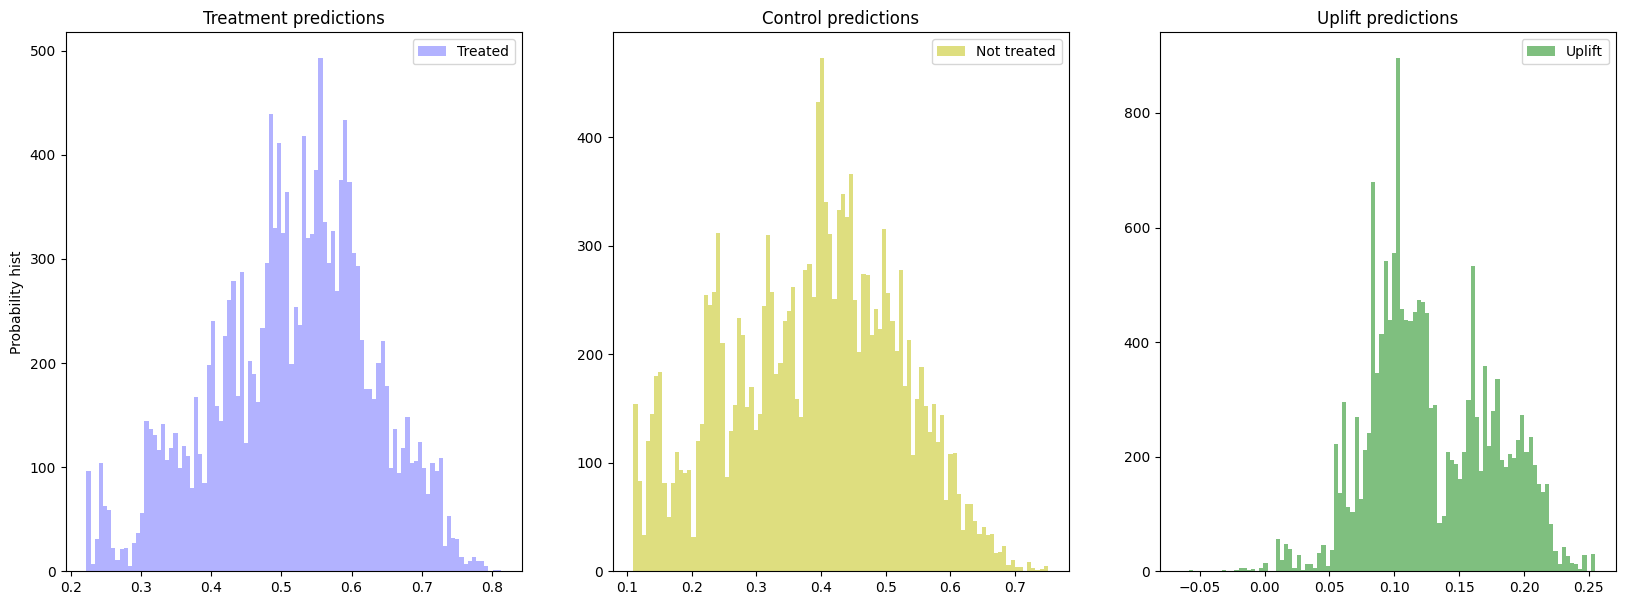

In [ ]:
plot_uplift_preds(trmnt_preds=sm_trmnt_preds, ctrl_preds=sm_ctrl_preds);

Видим, что распределение на первой гистограмме больше смещено вправо, что хорошо. На второй гистограмме распределение больше расположено в левой части, что является неплохим показателем. На третьей гистограмме мы видим, что большая часть значений располагается после 0. Это хороший признак: означает, что модель успешно идентифицирует подавляющее большинство пользователей, для которых воздействие будет иметь положительный эффект. Также это значит, что основная часть аудитории попадает в сегмент убеждаемых. Сравнительно  небольшое количество пользователей попадают в сегмент тех, кого лучше не трогать, так как отрицательных значений мало.

Отсортируем выборку по убыванию uplift.

In [ ]:
x_test_u = X_test
x_test_u['uplift'] = uplift_sm
x_test_u = x_test_u.sort_values(by=['uplift'], ascending=False)
x_test_u.head()

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,uplift
2174,-0.787936,-0.591028,0,1,Urban,1,Phone,0.254658
7140,-0.787936,-0.513770,0,1,Urban,1,Phone,0.254658
49945,-0.787936,-0.588490,0,1,Urban,1,Phone,0.254658
32342,-0.787936,-0.634048,0,1,Urban,1,Phone,0.254658
11380,-0.787936,-0.708534,0,1,Urban,1,Phone,0.254658


Разобьем на децили, как указано в задании. Это бывает необходимо, чтобы посмотреть, как будет вести себя метрика при разных значениях порога k.

In [ ]:
score_deciles, score_decile_bins = pd.qcut(x_test_u['uplift'], q=10, retbins=True, duplicates='drop')

Выведем, к какому децилю принадлежит каждый экземпляр, представленный краями интервала.

In [ ]:
score_deciles.head()

,uplift
2174,"(0.197, 0.255]"
7140,"(0.197, 0.255]"
49945,"(0.197, 0.255]"
32342,"(0.197, 0.255]"
11380,"(0.197, 0.255]"


In [ ]:
score_deciles.value_counts().sort_index()

,count
uplift,
"(-0.0659, 0.0738]",1610
"(0.0738, 0.0888]",1604
"(0.0888, 0.0998]",1588
"(0.0998, 0.107]",1608
"(0.107, 0.119]",1608
"(0.119, 0.133]",1620
"(0.133, 0.159]",1566
"(0.159, 0.175]",1601
"(0.175, 0.197]",1628


Выведем список ребер интервала.

In [ ]:
score_decile_bins

array([-0.06485245,  0.07378228,  0.08880008,  0.09976175,  0.10738896,
        0.11863344,  0.13260297,  0.15900827,  0.17520627,  0.19734842,
        0.25465787])

In [ ]:
x_test_u['decile_bin'] = score_deciles
x_test_u['treatment'] = treat_test
x_test_u['true'] = y_test
x_test_u[['treatment', 'true', 'uplift', 'decile_bin']].head()

,treatment,true,uplift,decile_bin
2174,0,0,0.254658,"(0.197, 0.255]"
7140,0,0,0.254658,"(0.197, 0.255]"
49945,1,0,0.254658,"(0.197, 0.255]"
32342,0,0,0.254658,"(0.197, 0.255]"
11380,0,0,0.254658,"(0.197, 0.255]"


In [ ]:
validation_treatment_mask = x_test_u['treatment'] == 1

Произведем подсчет средней conversion для каждого дециля.Хорошая модель должна показывать самую высокую конверсию в первом дециле (топ-10% самых перспективных клиентов) и постепенно снижаться к последнему децилю.

In [ ]:
mean_conversion = x_test_u[validation_treatment_mask].groupby('decile_bin')['true'].mean()
mean_conversion

/tmp/ipython-input-106820515.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_conversion = x_test_u[validation_treatment_mask].groupby('decile_bin')['true'].mean()


,true
decile_bin,
"(-0.0659, 0.0738]",0.198920
"(0.0738, 0.0888]",0.186845
"(0.0888, 0.0998]",0.145814
"(0.0998, 0.107]",0.154405
"(0.107, 0.119]",0.160898
"(0.119, 0.133]",0.180712
"(0.133, 0.159]",0.165839
"(0.159, 0.175]",0.180700
"(0.175, 0.197]",0.144968


Видим, что самая высокая конверсия действительно располагается в начале списка. Однако, в конце списка конверсия ведет себя не стабильно. Это может указывать на то, что модель возможно, ошибочно присвоила низкие оценки uplift'а пользователям, которые на самом деле очень хорошо реагируют на воздействие, и наоборот.



In [ ]:
metrics_df = uplift_by_percentile(y_test, uplift_sm, treat_test)

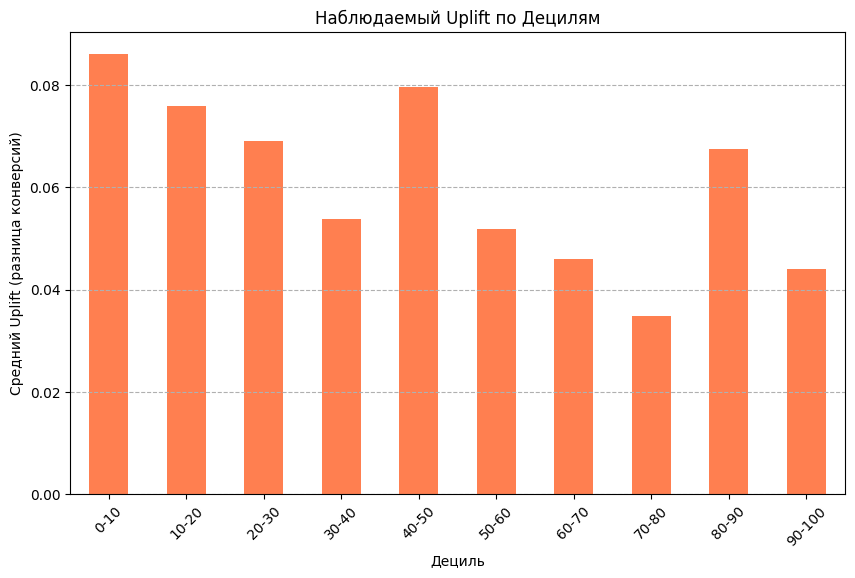

In [ ]:
plt.figure(figsize=(10, 6))
metrics_df['uplift'].plot(kind='bar', color='coral')

plt.title('Наблюдаемый Uplift по Децилям')
plt.xlabel('Дециль')
plt.ylabel('Средний Uplift (разница конверсий)')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--')
plt.show()

На графике убеждаемся, что столбцы ведут себя нестабильно. В начале графика наблюдается снижение, но затем происходит скачок. Затем снова наблюдается снижение, но опять происходит скачок. Причины этому могут быть такие:
- Модель не смогла найти закономерности – не уловила разницу между теми, кто отреагирует на воздействие, а кто – нет.
- Возможно, само маркетинговое воздействие не имеет значимого эффекта на аудиторию в целом, и модель просто не может найти несуществующий сигнал.

Попробуем построить графики plot_uplift_curve, чтобы понять прирост эффекта от воздействия и  plot_qini_curve, чтобы понять, насколько эффективнее модель выбирает клиентов для воздействия по сравнению со случайным выбором.


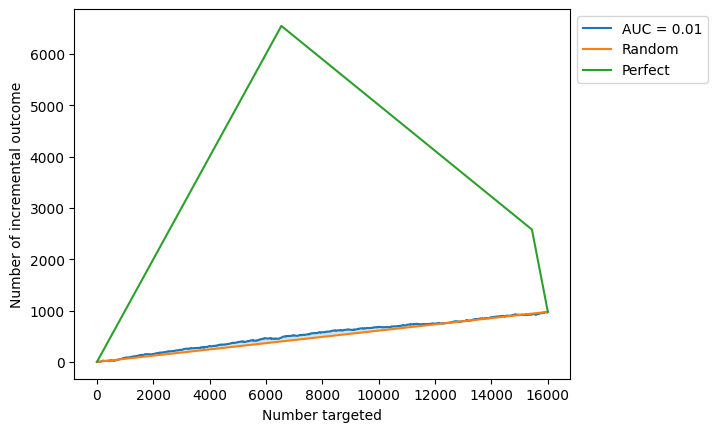

In [ ]:
plot_uplift_curve(y_test, uplift_sm, treat_test)

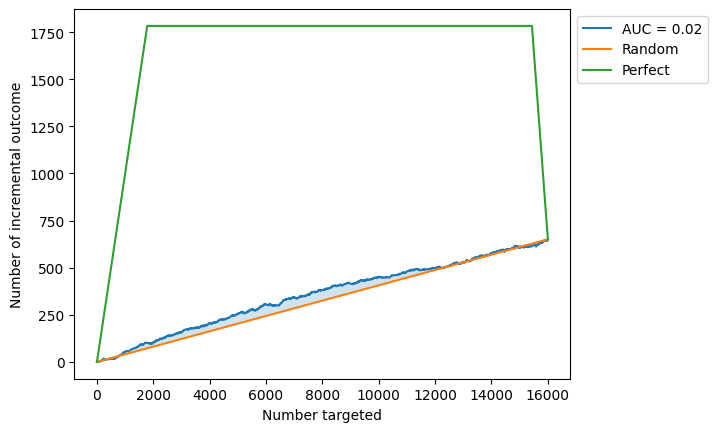

In [ ]:
plot_qini_curve(y_test, uplift_sm, treat_test)

Значения AUC 0.01 и 0.002 очень небольшие. Кривые распложены довольно далеко от идеальных.

Попробуем построить другие виды моделей.


# Построение модели с трансформацией таргета

Для реализации модели будем пробовать заменить целевое свойство на новое: целевое свойство будет  равно 1 в тех случаях, когда мы совершили воздействие - и все прошло хорошо, и в тех случаях, когда мы не совершали воздействие, и это завершилось плохо. Фактически четырех-классовая модель меняется на двухклассовую. Будет построен классификатор, который будет отвечать за вычисление свойства Z. Модель обычно аботает хорошо, так как задача становится тривиальной.



In [ ]:
ct = ClassTransformation(
    CatBoostClassifier(
        iterations=20,
        cat_features=cat_cols,
        eval_metric='AUC',
        auto_class_weights='Balanced',
        silent=True,
        random_state=42)
)

ct = ct.fit(X_train, y_train, treat_train)

uplift_ct = ct.predict(X_test)
ct_score_10 = uplift_at_k(y_true=y_test, uplift=uplift_ct, treatment=treat_test, strategy='by_group', k=0.1)
ct_score_20 = uplift_at_k(y_true=y_test, uplift=uplift_ct, treatment=treat_test, strategy='by_group', k=0.2)

print(ct_score_10)
print(ct_score_20)

0.10541818463684988
0.09483788076789382


Добавим значения в итоговую таблицу.

In [ ]:
models_results['approach'].append('ClassTransformation')
models_results['uplift@10%'].append(ct_score_10)
models_results['uplift@20%'].append(ct_score_20)

Попробуем построить графики plot_uplift_curve и plot_qini_curve.

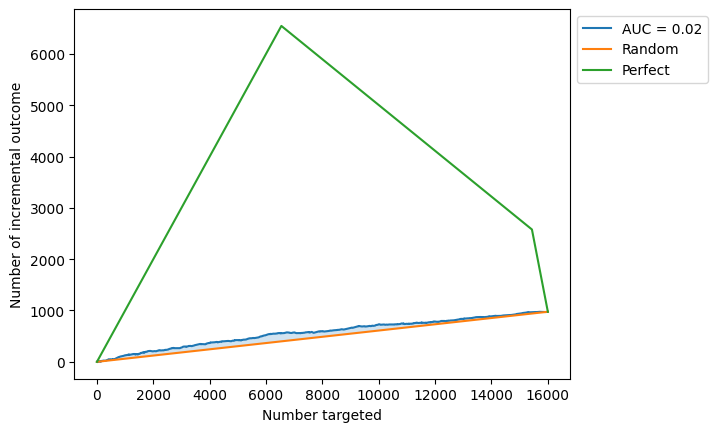

In [ ]:
plot_uplift_curve(y_test, uplift_ct, treat_test)

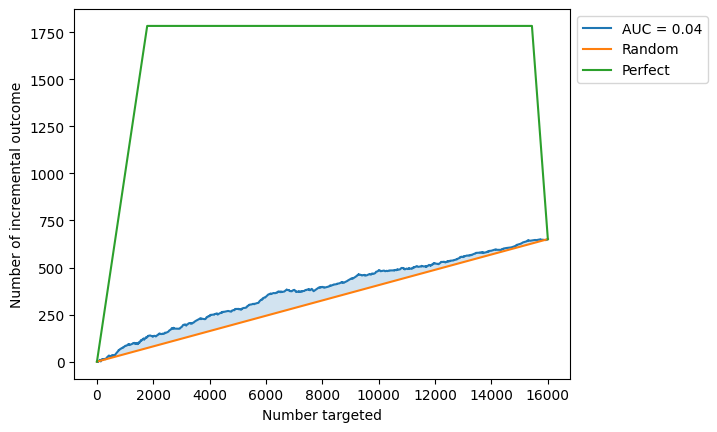

In [ ]:
plot_qini_curve(y_test, uplift_ct, treat_test)

Значения AUC немного больше, чем у предыдущей модели. Кривые занимают чуть большую площадь и всегда находятся выше случайной прямой.



# Построение двух независимых моделей

В источниках утверждается, что подход с двумя независимыми моделями может быть достаточно слабым, так как обе модели фокусируются на прогнозировании результата отдельно и поэтому могут пропустить "более слабые" различия в выборках.

0.060701777874865234
0.060701777874865234


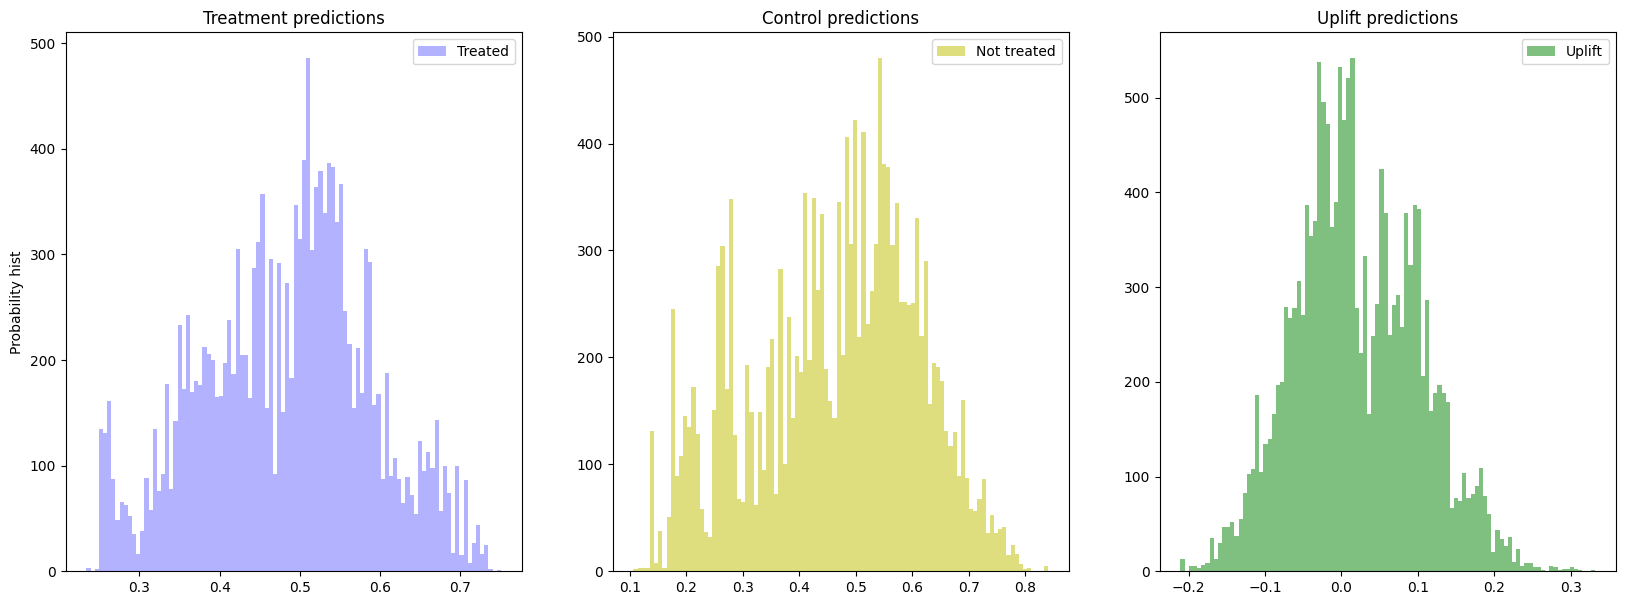

In [ ]:
tm = TwoModels(
    CatBoostClassifier(
        iterations=20,
        cat_features=cat_cols,
        eval_metric='AUC',
        auto_class_weights='Balanced',
        silent=True,
        random_state=42),
    CatBoostClassifier(
        iterations=20,
        cat_features=cat_cols,
        eval_metric='AUC',
        auto_class_weights='Balanced',
        silent=True,
        random_state=42),
    method='vanilla')
tm = tm.fit(X_train, y_train, treat_train)

uplift_tm = tm.predict(X_test)
tm_score_10 = uplift_at_k(y_true=y_test, uplift=uplift_tm, treatment=treat_test, strategy='by_group', k=0.1)
tm_score_20 = uplift_at_k(y_true=y_test, uplift=uplift_tm, treatment=treat_test, strategy='by_group', k=0.1)
print(tm_score_10)
print(tm_score_20)

models_results['approach'].append('TwoModels')
models_results['uplift@10%'].append(tm_score_10)
models_results['uplift@20%'].append(tm_score_20)

plot_uplift_preds(trmnt_preds=tm.trmnt_preds_, ctrl_preds=tm.ctrl_preds_);

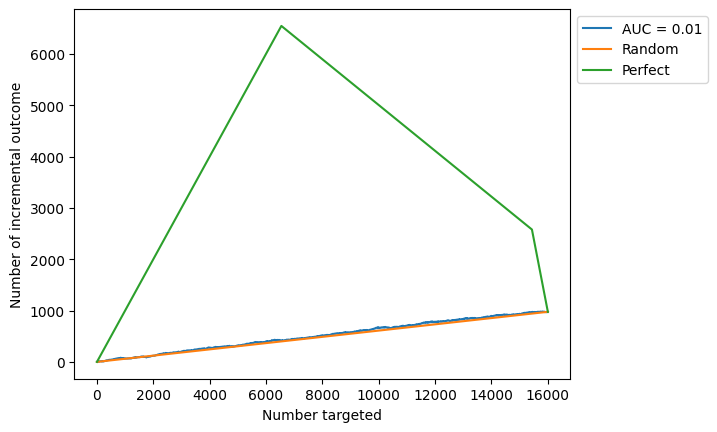

In [ ]:
plot_uplift_curve(y_test, uplift_tm, treat_test)

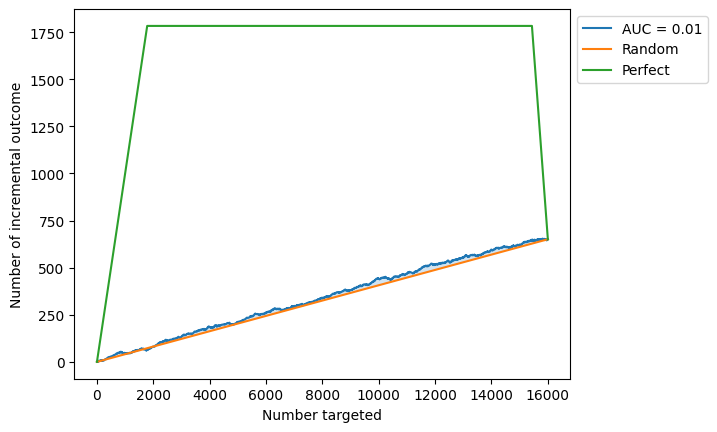

In [ ]:
plot_qini_curve(y_test, uplift_tm, treat_test)

Значения AUC самые низкие по сравнению с другими моделями.

# Выводы

В работе было проведено uplift-моделирование 3 способами:

• Одна модель с признаком коммуникации (S-learner).

• Модель с трансформацией таргета.

• Вариант с двумя независимыми моделями.

При построении всех моделей использовался CatBoostClassifier - является быстрой и точной моделью, довольно устойчивой к переобучению.

Была проведена оценка моделей при помощи метрик uplift@10% и uplift@20%.  Сравним получившиеся результаты метрик uplift@10% и uplift@20%.

In [ ]:
pd.DataFrame(data=models_results).sort_values('uplift@10%', ascending=False)

,approach,uplift@10%,uplift@20%
1,ClassTransformation,0.105418,0.094838
0,SoloModel,0.086981,0.079534
2,TwoModels,0.060702,0.060702


Видим, что самые высокие метрики получились при использовании модели с трансформацией классов: uplift@10%=0.105 и uplift@20%=0.095. Одна модель показала средний результат uplift@10%=0.087	и uplift@20%=0.08, и хуже всех справились две независимые модели uplift@10%=0.061 и uplift@20%=0.061.

Изобразим на графиках uplift-кривые без идельных графиков, чтобы лучше понять отличия между моделями. В каждой точке кривой сможем увидеть накопленный к этому моменту uplift. По оси X - процент аудитории, отсортированной по предсказанному uplift (от высокого к низкому). По оси Y - накопленный (кумулятивный) дополнительный эффект.

Solo Model


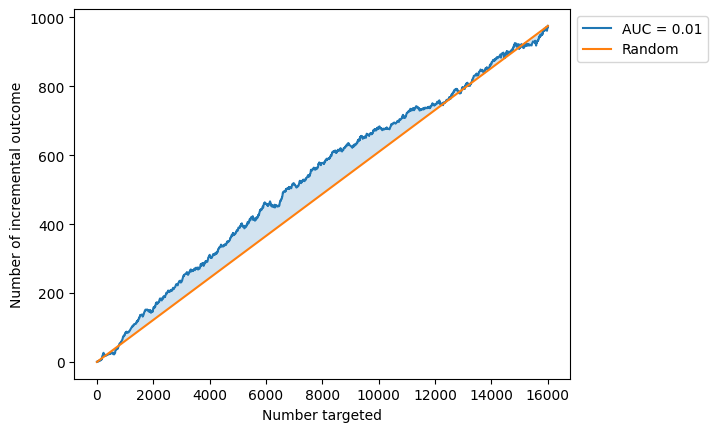

ClassTransform Model


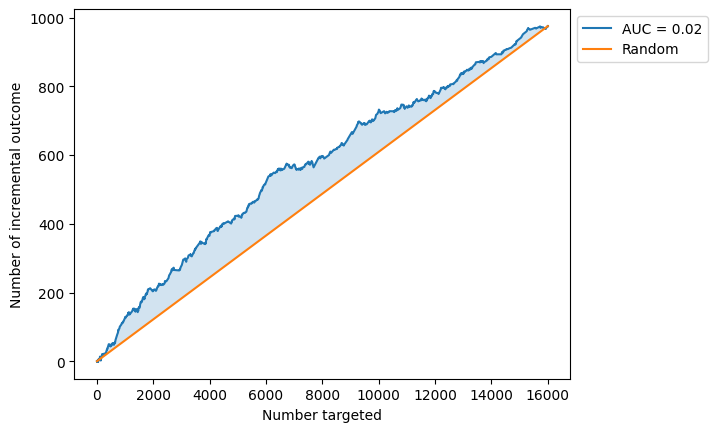

Two Model


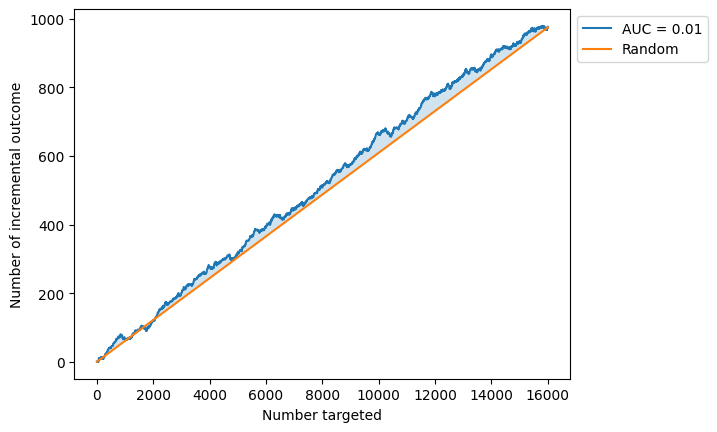

In [ ]:
print('Solo Model')
plot_uplift_curve(y_test, uplift_sm, treat_test, perfect=False)
plt.show()
print('ClassTransform Model')
plot_uplift_curve(y_test, uplift_ct, treat_test, perfect=False)
plt.show()
print('Two Model')
plot_uplift_curve(y_test, uplift_tm, treat_test, perfect=False)
plt.show()

На графиках uplift curve видим, что все кривые расположены выше случайной стратегии, и имеют общий положительный эффект. Solo Model в конце делает скачок и проходит ниже кривой, что указывает на ее нестабильность на этом участке. Наибольшую площадь под кривой и наибольшее расстояние от случайной стратегии имеет модель с трансформации классов. Ее применение может быть полезным для топ 10% клиентов, где она показывает наилучший результат.